# Predicción de Default — usando MLP

In [41]:
import os
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, balanced_accuracy_score, recall_score, f1_score, confusion_matrix
import gzip
import pickle
import json

df_test = pd.read_csv("../files/input/test_data.csv.zip", index_col=False, compression="zip")
df_train = pd.read_csv("../files/input/train_data.csv.zip", index_col=False, compression="zip")

### Paso 1 — Limpieza de datos
- Renombrar **default payment next month** a **`default`**.
- Eliminar **`ID`**.
- Tratar **N/A**.
- Reagrupar **`EDUCATION`** (>4 → others).

In [42]:
df_train.rename(columns={'default payment next month': 'default'}, inplace=True)
df_train['EDUCATION'] = df_train['EDUCATION'].apply(lambda x: 4 if x > 4 else x)
df_train = df_train[(df_train['EDUCATION'] != 0)]
df_train = df_train[(df_train['MARRIAGE'] != 0)]
df_train = df_train.drop(columns='ID')

df_test.rename(columns={'default payment next month': 'default'}, inplace=True)
df_test['EDUCATION'] = df_test['EDUCATION'].apply(lambda x: 4 if x > 4 else x)
df_test = df_test[(df_test['EDUCATION'] != 0)]
df_test = df_test[(df_test['MARRIAGE'] != 0)]
df_test = df_test.drop(columns='ID')

### Paso 2 — Partición de datasets
- Construir **x_train, y_train, x_test, y_test**.

In [43]:
x_train=df_train.drop(columns="default")
y_train=df_train["default"]
x_test=df_test.drop(columns="default")
y_test=df_test["default"]

### Paso 3 — Pipeline del modelo
- **OneHotEncoder → PCA → MinMaxScaler → SelectKBest → MLPClassifier**.

In [44]:
caracteristicas=["SEX","EDUCATION","MARRIAGE"]
carac_num=num_columns = [col for col in x_train.columns if col not in caracteristicas]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), caracteristicas),
        ('scaler',StandardScaler(with_mean=True, with_std=True),carac_num),
    ],
)

pipeline=Pipeline(
    [
        ("preprocessor",preprocessor),
        ('feature_selection',SelectKBest(score_func=f_classif)),
        ('pca',PCA()),
        ('classifier',MLPClassifier(max_iter=15000,random_state=17))
    ]
)


### Paso 4 — Optimización por validación cruzada
- **GridSearchCV** con **StratifiedKFold(10)** usando **balanced_accuracy**.

In [45]:
parametros = {
            'pca__n_components': [None],
            'feature_selection__k':[20],
            "classifier__hidden_layer_sizes": [(50, 30, 40, 60)],
            'classifier__alpha': [0.26],
            "classifier__learning_rate_init": [0.001],
}

modelo = GridSearchCV(
                        estimator=pipeline,
                        param_grid=parametros,
                        scoring='balanced_accuracy',  
                        cv=10,                                        
                        n_jobs=-1,                                  
                        verbose=1,
                        refit=True                              
)
modelo.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


,estimator,Pipeline(step...m_state=17))])
,param_grid,"{'classifier__alpha': [0.26], 'classifier__hidden_layer_sizes': [(50, ...)], 'classifier__learning_rate_init': [0.001], 'feature_selection__k': [20], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('scaler', ...)]"


### Paso 5 — Guardado del modelo
- Persistir mejor pipeline en **`files/models/model.pkl.gz`**.

In [46]:
direc_modelo = '../files/models'
os.makedirs(direc_modelo, exist_ok=True)

with gzip.open("../files/models/model.pkl.gz", "wb") as file:
    pickle.dump(modelo, file)

### Paso 6 — Métricas
- precision, balanced_accuracy, recall, f1_score a **metrics.json**.

In [47]:
y_train_pred = modelo.predict(x_train)
y_test_pred = modelo.predict(x_test)

metrics_train = {
        'type': 'metrics',
        'dataset': 'train',
        'precision': precision_score(y_train, y_train_pred, zero_division=0),
        'balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred, zero_division=0),
        'f1_score': f1_score(y_train, y_train_pred, zero_division=0)
    }

metrics_test = {
    'type': 'metrics',
    'dataset': 'test',
    'precision': precision_score(y_test, y_test_pred, zero_division=0),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred, zero_division=0),
    'f1_score': f1_score(y_test, y_test_pred, zero_division=0)
}

output_dir = '../files/output'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'metrics.json')
with open(output_path, 'w') as f: 
        f.write(json.dumps(metrics_train) + '\n')
        f.write(json.dumps(metrics_test) + '\n')

### Paso 7 — Matrices de confusión
- Calcular y guardar matrices de confusión (train/test) en **metrics.json**.

In [ ]:
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

train_cm_dict = {
    'type': 'cm_matrix',
	'dataset': 'train',
	'true_0': {"predicted_0": int(train_cm[0][0]), "predicted_1": int(train_cm[0][1])},
	'true_1': {"predicted_0": int(train_cm[1][0]), "predicted_1": int(train_cm[1][1])}
}

test_cm_dict = {
    'type': 'cm_matrix',
	'dataset': 'test',
	'true_0': {"predicted_0": int(test_cm[0][0]), "predicted_1": int(test_cm[0][1])},
	'true_1': {"predicted_0": int(test_cm[1][0]), "predicted_1": int(test_cm[1][1])}
}

output_path = '../files/output/metrics.json'

with open(output_path, 'a', encoding='utf-8') as f:
    json.dump(train_cm_dict, f, ensure_ascii=False) 
    f.write('\n')
    json.dump(test_cm_dict, f, ensure_ascii=False)  
    f.write('\n')


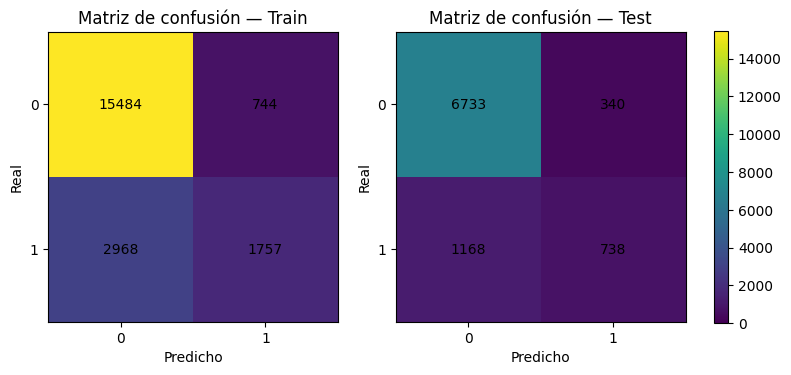

In [53]:
# === Confusion matrices (train/test) en una sola figura ===
from pathlib import Path
import json, numpy as np
import matplotlib.pyplot as plt

# 1) Cargar matrices desde ../files/output/metrics.json
p = Path("../files/output/metrics.json")
lines = [json.loads(l) for l in p.open("r", encoding="utf-8")]
get = lambda ds: next(d for d in lines if d.get("type")=="cm_matrix" and d.get("dataset")==ds)
to_mat = lambda d: np.array([[d["true_0"]["predicted_0"], d["true_0"]["predicted_1"]],
                             [d["true_1"]["predicted_0"], d["true_1"]["predicted_1"]]], int)
cm_tr, cm_te = to_mat(get("train")), to_mat(get("test"))

# 2) Plot side-by-side (mismo rango y colorbar compartida)
vmax = max(cm_tr.max(), cm_te.max())

fig, axes = plt.subplots(1, 2, figsize=(9, 3.8))
ims = []
for ax, cm, title in zip(axes, (cm_tr, cm_te), ("Matriz de confusión — Train", "Matriz de confusión — Test")):
    im = ax.imshow(cm, vmin=0, vmax=vmax, interpolation="nearest")
    ims.append(im)
    ax.set_title(title)
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
    ax.set_aspect("equal")
    # anotar valores
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(int(cm[i, j])), ha="center", va="center")

fig.colorbar(ims[0], ax=axes, fraction=0.046, pad=0.04)
plt.show()
